__1. EDA__

Train shape: (11017, 35)
Test shape: (5000, 35)

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries    

ApplicationDate                530
Age                            530
AnnualIncome                   530
CreditScore                   1031
LoanAmount                    1031
LoanDuration                   530
MaritalStatus                  530
NumberOfDependents             530
HomeOwnershipStatus            530
MonthlyDebtPayments           1031
CreditCardUtilizationRate      530
NumberOfOpenCreditLines        530
NumberOfCreditInquiries        530
DebtToIncomeRatio              530
BankruptcyHistory             1031
LoanPurpose                   1031
PreviousLoanDefaults           530
PaymentHistory                 530
LengthOfCreditHistory          530
SavingsAccountBalance          530
CheckingAccountBalance        1031
TotalAssets                   1031
TotalLiabilities               530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
JobTenure                      530
EmploymentStatus               530
EducationLevel                 530
Experience          

23059

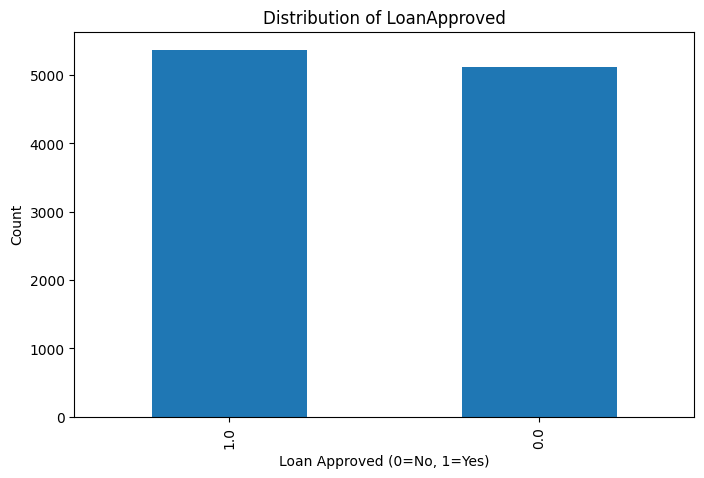

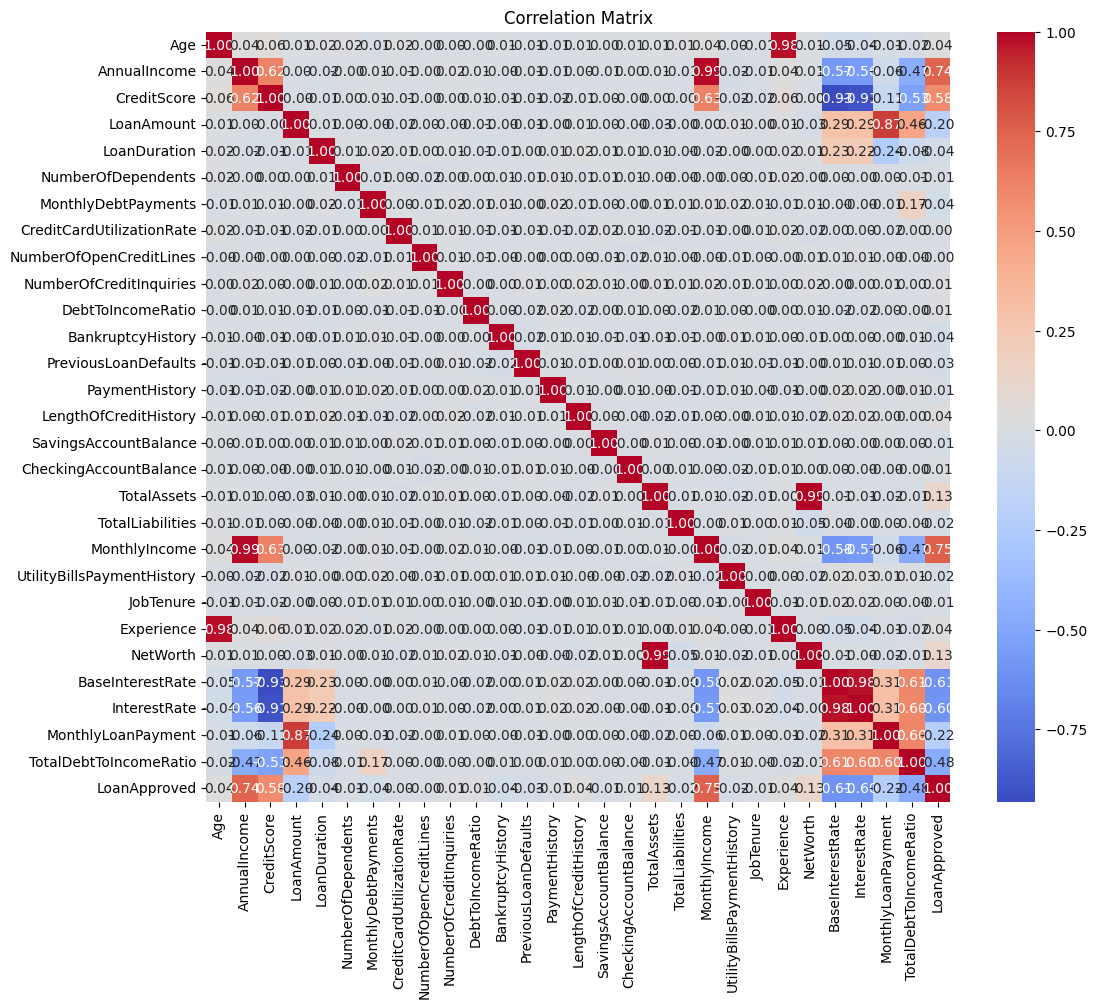


Correlation with target:
LoanApproved             1.000000
MonthlyIncome            0.754853
AnnualIncome             0.743034
CreditScore              0.581812
NetWorth                 0.129624
TotalAssets              0.129204
LengthOfCreditHistory    0.038509
Experience               0.036699
Age                      0.036580
DebtToIncomeRatio        0.014922
Name: LoanApproved, dtype: float64
Numeric features: 28
Categorical features: 6

Processed X shape: (11017, 10049)
Target shape: (11017,)


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

train = pd.read_csv('train_c.csv')
test = pd.read_csv('test_c.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("\nTrain info:")
print(train.info())
print("\nMissing values:")
display(train.isnull().sum())
display(train.isnull().sum().sum())

plt.figure(figsize=(8, 5))
train['LoanApproved'].value_counts().plot(kind='bar')
plt.title('Distribution of LoanApproved')
plt.xlabel('Loan Approved (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

numeric_cols = train.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 10))
corr_matrix = train[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

print("\nCorrelation with target:")
corr_with_target = corr_matrix['LoanApproved'].sort_values(ascending=False)
print(corr_with_target.head(10))

def prepare_data(df, is_train=True):
    data = df.copy()

    if is_train:
        if 'LoanApproved' in data.columns:
            y = data['LoanApproved']
            X = data.drop('LoanApproved', axis=1)
        else:
            raise ValueError("LoanApproved column not found in training data")
    else:
        X = data
        y = None

    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    print(f"Numeric features: {len(numeric_features)}")
    print(f"Categorical features: {len(categorical_features)}")

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    if is_train:
        X_processed = preprocessor.fit_transform(X)
        return X_processed, y, preprocessor, numeric_features, categorical_features
    else:
        return X, preprocessor, numeric_features, categorical_features

X_processed, y, preprocessor, num_features, cat_features = prepare_data(train, is_train=True)

print(f"\nProcessed X shape: {X_processed.shape}")
print(f"Target shape: {y.shape}")

__2. Реализация бэггинга__

In [29]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.tree import DecisionTreeClassifier

class CustomBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator=None, n_estimators=10, random_state=None):
        self.estimator = estimator or DecisionTreeClassifier(max_depth=5)
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.estimators_ = []
        self.n_features_ = None

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.n_features_ = X.shape[1]
        n_samples = X.shape[0]

        self.estimators_ = []
        for i in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]

            estimator = clone(self.estimator)
            estimator.fit(X_bootstrap, y_bootstrap)
            self.estimators_.append(estimator)

        return self

    def predict_proba(self, X):
        predictions = np.zeros((X.shape[0], 2))

        for estimator in self.estimators_:
            pred = estimator.predict_proba(X)
            predictions += pred

        predictions /= len(self.estimators_)
        return predictions

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    def get_params(self, deep=True):
        return {
            'estimator': self.estimator,
            'n_estimators': self.n_estimators,
            'random_state': self.random_state
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


__3. Тестирование беггинга__

In [31]:
from sklearn.ensemble import BaggingClassifier as SklearnBagging
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_test_data, y_test_data = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train_bag, X_test_bag, y_train_bag, y_test_bag = train_test_split(
    X_test_data, y_test_data, test_size=0.3, random_state=42
)

print("\n" + "="*50)
print("ТЕСТИРОВАНИЕ BAGGING CLASSIFIER")
print("="*50)

print("\nРазмеры тестовых данных:")
print(f"  Обучающая выборка: {X_train_bag.shape}")
print(f"  Тестовая выборка: {X_test_bag.shape}")

print("\n1. Наша реализация CustomBaggingClassifier:")
custom_bagging = CustomBaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5),
    n_estimators=10,
    random_state=42
)
custom_bagging.fit(X_train_bag, y_train_bag)
custom_pred = custom_bagging.predict(X_test_bag)
custom_accuracy = accuracy_score(y_test_bag, custom_pred)
print(f"   Accuracy: {custom_accuracy:.4f}")

print("\n2. Sklearn реализация BaggingClassifier:")

try:
    sklearn_bagging = SklearnBagging(
        estimator=DecisionTreeClassifier(max_depth=5),
        n_estimators=10,
        random_state=42
    )
    print("   Используется параметр 'estimator'")
except TypeError:
    sklearn_bagging = SklearnBagging(
        base_estimator=DecisionTreeClassifier(max_depth=5),
        n_estimators=10,
        random_state=42
    )
    print("   Используется параметр 'base_estimator'")

sklearn_bagging.fit(X_train_bag, y_train_bag)
sklearn_pred = sklearn_bagging.predict(X_test_bag)
sklearn_accuracy = accuracy_score(y_test_bag, sklearn_pred)
print(f"   Accuracy: {sklearn_accuracy:.4f}")


ТЕСТИРОВАНИЕ BAGGING CLASSIFIER

Размеры тестовых данных:
  Обучающая выборка: (700, 20)
  Тестовая выборка: (300, 20)

1. Наша реализация CustomBaggingClassifier:
   Accuracy: 0.8800

2. Sklearn реализация BaggingClassifier:
   Используется параметр 'estimator'
   Accuracy: 0.8733


__4. Релизация градиентного бустинга__

In [ ]:
from sklearn.tree import DecisionTreeRegressor

class CustomGradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3,
                 min_samples_split=2, min_samples_leaf=1, random_state=None):

        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees_ = []
        self.initial_prediction_ = None

    def _sigmoid(self, x):
        x = np.clip(x, -700, 700)
        return 1.0 / (1.0 + np.exp(-x))

    def _log_loss_gradient(self, y_true, y_pred_proba):
        return y_true - y_pred_proba

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples = X.shape[0]

        pos_class_proba = np.sum(y) / n_samples
        eps = 1e-10
        pos_class_proba = np.clip(pos_class_proba, eps, 1 - eps)
        self.initial_prediction_ = np.log(pos_class_proba / (1 - pos_class_proba))
        current_predictions = np.full(n_samples, self.initial_prediction_)

        self.trees_ = []

        for i in range(self.n_estimators):
            probabilities = self._sigmoid(current_predictions)

            residuals = self._log_loss_gradient(y, probabilities)

            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state
            )
            tree.fit(X, residuals)

            tree_prediction = tree.predict(X)
            current_predictions += self.learning_rate * tree_prediction

            self.trees_.append(tree)

            if (i + 1) % 20 == 0:
                current_proba = self._sigmoid(current_predictions)
                current_pred = (current_proba > 0.5).astype(int)
                accuracy = np.mean(current_pred == y)
                print(f"  Дерево {i+1}/{self.n_estimators}, Accuracy: {accuracy:.4f}")

        return self

    def predict_proba(self, X):

        predictions = np.full(X.shape[0], self.initial_prediction_)

        for tree in self.trees_:
            predictions += self.learning_rate * tree.predict(X)

        proba_positive = self._sigmoid(predictions)
        proba_negative = 1 - proba_positive

        return np.column_stack([proba_negative, proba_positive])

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] > 0.5).astype(int)

    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'learning_rate': self.learning_rate,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'random_state': self.random_state
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

__5. Тестирование градиентного бустинга__

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier as SklearnGBC
from sklearn.metrics import roc_auc_score

print("\n" + "="*60)
print("ТЕСТИРОВАНИЕ GRADIENT BOOSTING CLASSIFIER")
print("="*60)

print("\nРазмеры данных:")
print(f"  Обучающая выборка: {X_train_bag.shape}")
print(f"  Тестовая выборка: {X_test_bag.shape}")

print("\n1. Наша реализация CustomGradientBoostingClassifier:")
custom_gb = CustomGradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
custom_gb.fit(X_train_bag, y_train_bag)
custom_gb_pred = custom_gb.predict(X_test_bag)
custom_gb_proba = custom_gb.predict_proba(X_test_bag)[:, 1]
custom_gb_accuracy = accuracy_score(y_test_bag, custom_gb_pred)
custom_gb_auc = roc_auc_score(y_test_bag, custom_gb_proba)
print(f"   Accuracy: {custom_gb_accuracy:.4f}")
print(f"   ROC-AUC:  {custom_gb_auc:.4f}")

print("\n2. Sklearn реализация GradientBoostingClassifier:")
sklearn_gb = SklearnGBC(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
sklearn_gb.fit(X_train_bag, y_train_bag)
sklearn_gb_pred = sklearn_gb.predict(X_test_bag)
sklearn_gb_proba = sklearn_gb.predict_proba(X_test_bag)[:, 1]
sklearn_gb_accuracy = accuracy_score(y_test_bag, sklearn_gb_pred)
sklearn_gb_auc = roc_auc_score(y_test_bag, sklearn_gb_proba)
print(f"   Accuracy: {sklearn_gb_accuracy:.4f}")
print(f"   ROC-AUC:  {sklearn_gb_auc:.4f}")

print("\n" + "="*60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
print("="*60)
display(f"Custom Gradient Boosting Accuracy: {custom_gb_accuracy:.4f}")
display(f"Sklearn Gradient Boosting Accuracy: {sklearn_gb_accuracy:.4f}")
display(f"Разница в Accuracy: {abs(custom_gb_accuracy - sklearn_gb_accuracy):.4f}")
print()
display(f"Custom Gradient Boosting ROC-AUC: {custom_gb_auc:.4f}")
display(f"Sklearn Gradient Boosting ROC-AUC: {sklearn_gb_auc:.4f}")
display(f"Разница в ROC-AUC: {abs(custom_gb_auc - sklearn_gb_auc):.4f}")

match_percentage = np.mean(custom_gb_pred == sklearn_gb_pred) * 100
print(f"\nСовпадение предсказаний: {match_percentage:.1f}%")


ТЕСТИРОВАНИЕ GRADIENT BOOSTING CLASSIFIER

Размеры данных:
  Обучающая выборка: (700, 20)
  Тестовая выборка: (300, 20)

1. Наша реализация CustomGradientBoostingClassifier:
  Дерево 20/50, Accuracy: 0.9314
  Дерево 40/50, Accuracy: 0.9343
   Accuracy: 0.8633
   ROC-AUC:  0.9242

2. Sklearn реализация GradientBoostingClassifier:
   Accuracy: 0.8667
   ROC-AUC:  0.9283

СРАВНЕНИЕ РЕЗУЛЬТАТОВ:


'Custom Gradient Boosting Accuracy: 0.8633'

'Sklearn Gradient Boosting Accuracy: 0.8667'

'Разница в Accuracy: 0.0033'

'Custom Gradient Boosting ROC-AUC: 0.9242'

'Sklearn Gradient Boosting ROC-AUC: 0.9283'

'Разница в ROC-AUC: 0.0041'


Совпадение предсказаний: 98.3%


__6. Сравнение алгоритмов бустинга__

In [34]:
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("СРАВНЕНИЕ РАЗЛИЧНЫХ РЕАЛИЗАЦИЙ ГРАДИЕНТНОГО БУСТИНГА")
print("="*70)

try:
    import xgboost as xgb
    XGB_INSTALLED = True
except ImportError:
    XGB_INSTALLED = False
    print("XGBoost не установлен. Установите: pip install xgboost")

try:
    import lightgbm as lgb
    LGBM_INSTALLED = True
except ImportError:
    LGBM_INSTALLED = False
    print("LightGBM не установлен. Установите: pip install lightgbm")

try:
    import catboost as cb
    CATBOOST_INSTALLED = True
except ImportError:
    CATBOOST_INSTALLED = False
    print("CatBoost не установлен. Установите: pip install catboost")

print(f"\nПроверка данных на NaN:")
display(f"Количество NaN в y: {np.isnan(y).sum() if hasattr(y, '__len__') else 0}")

if np.isnan(y).any():
    print("Удаляем строки с NaN в целевой переменной...")
    mask = ~np.isnan(y)
    X_processed_clean = X_processed[mask]
    y_clean = y[mask]
    display(f"До очистки: {X_processed.shape[0]} строк")
    display(f"После очистки: {X_processed_clean.shape[0]} строк")
else:
    X_processed_clean = X_processed
    y_clean = y
    print("NaN значений в y не обнаружено.")

X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_processed_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print(f"\nРазмеры данных для сравнения моделей:")
display(f"  Train: {X_train_full.shape}")
display(f"  Validation: {X_val.shape}")

print(f"\nРаспределение классов в train:")
unique, counts = np.unique(y_train_full, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Класс {cls}: {cnt} ({cnt/len(y_train_full)*100:.1f}%)")

print(f"\nРаспределение классов в validation:")
unique, counts = np.unique(y_val, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Класс {cls}: {cnt} ({cnt/len(y_val)*100:.1f}%)")

results = {}

print("\n" + "-"*50)
print("1. Sklearn GradientBoostingClassifier...")
gb_sklearn = SklearnGBC(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    verbose=0
)
gb_sklearn.fit(X_train_full, y_train_full)
gb_sklearn_proba = gb_sklearn.predict_proba(X_val)[:, 1]
gb_sklearn_auc = roc_auc_score(y_val, gb_sklearn_proba)
results['Sklearn GBM'] = gb_sklearn_auc
display(f"   ROC-AUC: {gb_sklearn_auc:.4f}")

if XGB_INSTALLED:
    print("\n2. XGBoost Classifier...")
    gb_xgb = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    gb_xgb.fit(X_train_full, y_train_full)
    gb_xgb_proba = gb_xgb.predict_proba(X_val)[:, 1]
    gb_xgb_auc = roc_auc_score(y_val, gb_xgb_proba)
    results['XGBoost'] = gb_xgb_auc
    display(f"   ROC-AUC: {gb_xgb_auc:.4f}")
else:
    print("\n2. XGBoost - пропущен (не установлен)")

if LGBM_INSTALLED:
    print("\n3. LightGBM Classifier...")
    gb_lgbm = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        verbosity=-1
    )
    gb_lgbm.fit(X_train_full, y_train_full)
    gb_lgbm_proba = gb_lgbm.predict_proba(X_val)[:, 1]
    gb_lgbm_auc = roc_auc_score(y_val, gb_lgbm_proba)
    results['LightGBM'] = gb_lgbm_auc
    display(f"   ROC-AUC: {gb_lgbm_auc:.4f}")
else:
    print("\n3. LightGBM - пропущен (не установлен)")

if CATBOOST_INSTALLED:
    print("\n4. CatBoost Classifier...")
    gb_catboost = cb.CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=3,
        random_state=42,
        verbose=False
    )
    gb_catboost.fit(X_train_full, y_train_full)
    gb_catboost_proba = gb_catboost.predict_proba(X_val)[:, 1]
    gb_catboost_auc = roc_auc_score(y_val, gb_catboost_proba)
    results['CatBoost'] = gb_catboost_auc
    display(f"   ROC-AUC: {gb_catboost_auc:.4f}")
else:
    print("\n4. CatBoost - пропущен (не установлен)")

print("\n" + "="*70)
print("ИТОГИ СРАВНЕНИЯ (ROC-AUC):")
print("="*70)
for model_name, auc_score in sorted(results.items(), key=lambda x: x[1], reverse=True):
    display(f"{model_name:20} : {auc_score:.4f}")

if results:
    best_model_name = max(results, key=results.get)
    best_model_score = results[best_model_name]
    display(f"Лучшая модель: {best_model_name} с ROC-AUC = {best_model_score:.4f}")
else:
    print("\n⚠ Нет установленных библиотек для сравнения!")
    best_model_name = 'Sklearn GBM'
    best_model_score = gb_sklearn_auc

print(f"\nРекомендация: использовать {best_model_name} для дальнейшей работы.")


СРАВНЕНИЕ РАЗЛИЧНЫХ РЕАЛИЗАЦИЙ ГРАДИЕНТНОГО БУСТИНГА

Проверка данных на NaN:


'Количество NaN в y: 530'

Удаляем строки с NaN в целевой переменной...


'До очистки: 11017 строк'

'После очистки: 10487 строк'


Размеры данных для сравнения моделей:


'  Train: (8389, 10049)'

'  Validation: (2098, 10049)'


Распределение классов в train:
  Класс 0.0: 4096 (48.8%)
  Класс 1.0: 4293 (51.2%)

Распределение классов в validation:
  Класс 0.0: 1024 (48.8%)
  Класс 1.0: 1074 (51.2%)

--------------------------------------------------
1. Sklearn GradientBoostingClassifier...


'   ROC-AUC: 0.9803'


2. XGBoost Classifier...


'   ROC-AUC: 0.9805'


3. LightGBM Classifier...


'   ROC-AUC: 0.9809'


4. CatBoost Classifier...


'   ROC-AUC: 0.9794'


ИТОГИ СРАВНЕНИЯ (ROC-AUC):


'LightGBM             : 0.9809'

'XGBoost              : 0.9805'

'Sklearn GBM          : 0.9803'

'CatBoost             : 0.9794'

'Лучшая модель: LightGBM с ROC-AUC = 0.9809'


Рекомендация: использовать LightGBM для дальнейшей работы.


__7. ПОДБОР ГИПЕРПАРАМЕТРОВ С OPTUNA__

In [35]:
print("\n" + "="*70)
print("ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ LIGHTGBM С OPTUNA")
print("="*70)

try:
    import optuna
    from sklearn.model_selection import cross_val_score
    import warnings
    warnings.filterwarnings('ignore')

    print("Optuna установлена ✓")

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'num_leaves': trial.suggest_int('num_leaves', 20, 200),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        }

        model = lgb.LGBMClassifier(
            **params,
            random_state=42,
            verbosity=-1,
            n_jobs=-1
        )

        score = cross_val_score(
            model,
            X_train_full,
            y_train_full,
            cv=3,
            scoring='roc_auc',
            n_jobs=-1
        ).mean()

        return score

    print("Начинаем подбор гиперпараметров...")
    study = optuna.create_study(direction='maximize')

    study.optimize(objective, n_trials=30, show_progress_bar=True)

    print(f"\nЛучшее значение ROC-AUC: {study.best_value:.4f}")
    print("Лучшие гиперпараметры:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

    print("\nОбучение финальной модели с лучшими гиперпараметрами...")
    best_params = study.best_params
    final_model = lgb.LGBMClassifier(
        **best_params,
        random_state=42,
        verbosity=-1,
        n_jobs=-1
    )
    final_model.fit(X_train_full, y_train_full)

    final_pred_proba = final_model.predict_proba(X_val)[:, 1]
    final_auc = roc_auc_score(y_val, final_pred_proba)
    print(f"ROC-AUC на валидации: {final_auc:.4f}")

    improvement = final_auc - results['LightGBM']
    print(f"Улучшение по сравнению с моделью по умолчанию: {improvement:.4f}")

except ImportError:
    print("Optuna не установлена. Установите: pip install optuna")
    print("Используем модель с гиперпараметрами по умолчанию.")
    final_model = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        verbosity=-1,
        n_jobs=-1
    )
    final_model.fit(X_train_full, y_train_full)
    final_auc = results['LightGBM']

[I 2025-12-07 14:02:37,991] A new study created in memory with name: no-name-c98c2a1c-8e6d-4cda-9358-b8d708c40025



ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ LIGHTGBM С OPTUNA
Optuna установлена ✓
Начинаем подбор гиперпараметров...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-07 14:03:00,403] Trial 0 finished with value: 0.9829854707322162 and parameters: {'n_estimators': 159, 'learning_rate': 0.13696379707221218, 'max_depth': 4, 'num_leaves': 164, 'min_child_samples': 43, 'subsample': 0.9044310856528919, 'colsample_bytree': 0.9678135831983277, 'reg_alpha': 0.000513645075192009, 'reg_lambda': 0.0012756741888563182}. Best is trial 0 with value: 0.9829854707322162.
[I 2025-12-07 14:03:09,899] Trial 1 finished with value: 0.9813390727522794 and parameters: {'n_estimators': 202, 'learning_rate': 0.012792255112133612, 'max_depth': 11, 'num_leaves': 114, 'min_child_samples': 49, 'subsample': 0.6748401708618235, 'colsample_bytree': 0.6618118102984129, 'reg_alpha': 0.1844379308692488, 'reg_lambda': 0.02216878093660377}. Best is trial 0 with value: 0.9829854707322162.
[I 2025-12-07 14:03:17,875] Trial 2 finished with value: 0.9822054580144889 and parameters: {'n_estimators': 139, 'learning_rate': 0.04631442302747081, 'max_depth': 13, 'num_leaves': 111, 'm

__8. Реализация метрик классификации__

In [38]:
print("\n" + "="*70)
print("РЕАЛИЗАЦИЯ МЕТРИК КЛАССИФИКАЦИИ")
print("="*70)

import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

class CustomMetrics:
    @staticmethod
    def confusion_matrix(y_true, y_pred):

        y_true_np = np.array(y_true)
        y_pred_np = np.array(y_pred)

        tp = np.sum((y_true_np == 1) & (y_pred_np == 1))
        fp = np.sum((y_true_np == 0) & (y_pred_np == 1))
        tn = np.sum((y_true_np == 0) & (y_pred_np == 0))
        fn = np.sum((y_true_np == 1) & (y_pred_np == 0))
        return tp, fp, tn, fn

    @staticmethod
    def accuracy(y_true, y_pred):
        tp, fp, tn, fn = CustomMetrics.confusion_matrix(y_true, y_pred)
        return (tp + tn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) > 0 else 0

    @staticmethod
    def precision(y_true, y_pred):
        tp, fp, tn, fn = CustomMetrics.confusion_matrix(y_true, y_pred)
        return tp / (tp + fp) if (tp + fp) > 0 else 0

    @staticmethod
    def recall(y_true, y_pred):
        tp, fp, tn, fn = CustomMetrics.confusion_matrix(y_true, y_pred)
        return tp / (tp + fn) if (tp + fn) > 0 else 0

    @staticmethod
    def f1_score(y_true, y_pred):
        prec = CustomMetrics.precision(y_true, y_pred)
        rec = CustomMetrics.recall(y_true, y_pred)
        return 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

    @staticmethod
    def roc_auc(y_true, y_pred_proba):
        y_true_np = np.array(y_true)
        y_pred_proba_np = np.array(y_pred_proba)
        sorted_indices = np.argsort(y_pred_proba_np)[::-1]
        y_true_sorted = y_true_np[sorted_indices]
        y_pred_proba_sorted = y_pred_proba_np[sorted_indices]

        tpr = []
        fpr = []

        thresholds = np.sort(np.unique(y_pred_proba_sorted))[::-1]

        for threshold in thresholds:
            y_pred = (y_pred_proba_sorted >= threshold).astype(int)
            tp = np.sum((y_true_sorted == 1) & (y_pred == 1))
            fp = np.sum((y_true_sorted == 0) & (y_pred == 1))
            tn = np.sum((y_true_sorted == 0) & (y_pred == 0))
            fn = np.sum((y_true_sorted == 1) & (y_pred == 0))

            tpr_val = tp / (tp + fn) if (tp + fn) > 0 else 0
            fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0

            tpr.append(tpr_val)
            fpr.append(fpr_val)

        tpr = np.array([0] + tpr)
        fpr = np.array([0] + fpr)

        auc = 0
        for i in range(1, len(fpr)):
            auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2

        return auc

    @staticmethod
    def pr_auc(y_true, y_pred_proba):
        y_true_np = np.array(y_true)
        y_pred_proba_np = np.array(y_pred_proba)

        sorted_indices = np.argsort(y_pred_proba_np)[::-1]
        y_true_sorted = y_true_np[sorted_indices]
        y_pred_proba_sorted = y_pred_proba_np[sorted_indices]

        precision_vals = []
        recall_vals = []

        thresholds = np.sort(np.unique(y_pred_proba_sorted))[::-1]

        for threshold in thresholds:
            y_pred = (y_pred_proba_sorted >= threshold).astype(int)
            tp = np.sum((y_true_sorted == 1) & (y_pred == 1))
            fp = np.sum((y_true_sorted == 0) & (y_pred == 1))
            fn = np.sum((y_true_sorted == 1) & (y_pred == 0))

            prec = tp / (tp + fp) if (tp + fp) > 0 else 0
            rec = tp / (tp + fn) if (tp + fn) > 0 else 0

            precision_vals.append(prec)
            recall_vals.append(rec)

        precision_vals = [1] + precision_vals
        recall_vals = [0] + recall_vals

        auc = 0
        for i in range(1, len(recall_vals)):
            auc += (recall_vals[i] - recall_vals[i-1]) * (precision_vals[i] + precision_vals[i-1]) / 2

        return auc

print("\nТестирование метрик на валидационных данных:")

y_pred_val = final_model.predict(X_val)
y_pred_proba_val = final_model.predict_proba(X_val)[:, 1]

display(f"Тип y_val: {type(y_val)}")
display(f"Тип y_pred_val: {type(y_pred_val)}")
display(f"Тип y_pred_proba_val: {type(y_pred_proba_val)}")

y_val_np = np.array(y_val)

custom_acc = CustomMetrics.accuracy(y_val_np, y_pred_val)
sklearn_acc = accuracy_score(y_val_np, y_pred_val)
display(f"1. Accuracy:")
display(f"   Custom: {custom_acc:.6f}")
display(f"   Sklearn: {sklearn_acc:.6f}")
display(f"   Разница: {abs(custom_acc - sklearn_acc):.6f}")

custom_prec = CustomMetrics.precision(y_val_np, y_pred_val)
sklearn_prec = precision_score(y_val_np, y_pred_val)
display(f"2. Precision:")
display(f"   Custom: {custom_prec:.6f}")
display(f"   Sklearn: {sklearn_prec:.6f}")
display(f"   Разница: {abs(custom_prec - sklearn_prec):.6f}")

custom_rec = CustomMetrics.recall(y_val_np, y_pred_val)
sklearn_rec = recall_score(y_val_np, y_pred_val)
display(f"3. Recall:")
display(f"   Custom: {custom_rec:.6f}")
display(f"   Sklearn: {sklearn_rec:.6f}")
display(f"   Разница: {abs(custom_rec - sklearn_rec):.6f}")

custom_f1 = CustomMetrics.f1_score(y_val_np, y_pred_val)
sklearn_f1 = f1_score(y_val_np, y_pred_val)
display(f"4. F1-Score:")
display(f"   Custom: {custom_f1:.6f}")
display(f"   Sklearn: {sklearn_f1:.6f}")
display(f"   Разница: {abs(custom_f1 - sklearn_f1):.6f}")

custom_roc_auc = CustomMetrics.roc_auc(y_val_np, y_pred_proba_val)
sklearn_roc_auc = roc_auc_score(y_val_np, y_pred_proba_val)
display(f"5. ROC-AUC (дополнительная метрика):")
display(f"   Custom: {custom_roc_auc:.6f}")
display(f"   Sklearn: {sklearn_roc_auc:.6f}")
display(f"   Разница: {abs(custom_roc_auc - sklearn_roc_auc):.6f}")

custom_pr_auc = CustomMetrics.pr_auc(y_val_np, y_pred_proba_val)
sklearn_pr_auc = average_precision_score(y_val_np, y_pred_proba_val)
display(f"6. PR-AUC (дополнительная метрика):")
display(f"   Custom: {custom_pr_auc:.6f}")
display(f"   Sklearn: {sklearn_pr_auc:.6f}")
display(f"   Разница: {abs(custom_pr_auc - sklearn_pr_auc):.6f}")

print("\n" + "="*70)
print("МАТРИЦА ОШИБОК (CONFUSION MATRIX):")
print("="*70)
tp, fp, tn, fn = CustomMetrics.confusion_matrix(y_val_np, y_pred_val)
display(f"True Positives (TP):  {tp}")
display(f"False Positives (FP): {fp}")
display(f"True Negatives (TN):  {tn}")
display(f"False Negatives (FN): {fn}")
display(f"Итого: {tp + fp + tn + fn} образцов")


РЕАЛИЗАЦИЯ МЕТРИК КЛАССИФИКАЦИИ

Тестирование метрик на валидационных данных:


"Тип y_val: <class 'pandas.core.series.Series'>"

"Тип y_pred_val: <class 'numpy.ndarray'>"

"Тип y_pred_proba_val: <class 'numpy.ndarray'>"

'1. Accuracy:'

'   Custom: 0.923737'

'   Sklearn: 0.923737'

'   Разница: 0.000000'

'2. Precision:'

'   Custom: 0.920037'

'   Sklearn: 0.920037'

'   Разница: 0.000000'

'3. Recall:'

'   Custom: 0.932030'

'   Sklearn: 0.932030'

'   Разница: 0.000000'

'4. F1-Score:'

'   Custom: 0.925994'

'   Sklearn: 0.925994'

'   Разница: 0.000000'

'5. ROC-AUC (дополнительная метрика):'

'   Custom: 0.981909'

'   Sklearn: 0.981909'

'   Разница: 0.000000'

'6. PR-AUC (дополнительная метрика):'

'   Custom: 0.983778'

'   Sklearn: 0.983785'

'   Разница: 0.000007'


МАТРИЦА ОШИБОК (CONFUSION MATRIX):


'True Positives (TP):  1001'

'False Positives (FP): 87'

'True Negatives (TN):  937'

'False Negatives (FN): 73'

'Итого: 2098 образцов'

__9. Подготовка sumbission__

In [39]:
print("\n" + "="*70)
print("ПОДГОТОВКА SUBMISSION ФАЙЛА ДЛЯ KAGGLE")
print("="*70)

print("Подготовка тестовых данных...")
X_test_processed = preprocessor.transform(test)

print(f"Размер тестовых данных: {X_test_processed.shape}")

print("Генерация предсказаний...")
test_predictions = final_model.predict_proba(X_test_processed)[:, 1]

print("Создание submission файла...")
submission = pd.DataFrame({
    'ID': test.index,
    'LoanApproved': test_predictions
})

submission_file = 'submission_.csv'
submission.to_csv(submission_file, index=False)
print(f"Submission файл сохранен как: {submission_file}")

print(f"\nПроверка submission файла:")
print(f"Размер: {submission.shape}")
print(f"Первые 5 строк:")
print(submission.head())
print(f"\nСтатистика предсказаний:")
print(f"  Минимум: {submission['LoanApproved'].min():.4f}")
print(f"  Максимум: {submission['LoanApproved'].max():.4f}")
print(f"  Среднее: {submission['LoanApproved'].mean():.4f}")
print(f"  Медиана: {submission['LoanApproved'].median():.4f}")

threshold = 0.5
binary_predictions = (test_predictions > threshold).astype(int)
print(f"\nБинарные предсказания (порог = {threshold}):")
print(f"  Класс 0: {np.sum(binary_predictions == 0)}")
print(f"  Класс 1: {np.sum(binary_predictions == 1)}")


ПОДГОТОВКА SUBMISSION ФАЙЛА ДЛЯ KAGGLE
Подготовка тестовых данных...
Размер тестовых данных: (5000, 10049)
Генерация предсказаний...
Создание submission файла...
Submission файл сохранен как: submission_.csv

Проверка submission файла:
Размер: (5000, 2)
Первые 5 строк:
   ID  LoanApproved
0   0      0.999092
1   1      0.001954
2   2      0.999149
3   3      0.999634
4   4      0.999450

Статистика предсказаний:
  Минимум: 0.0001
  Максимум: 0.9999
  Среднее: 0.5190
  Медиана: 0.6451

Бинарные предсказания (порог = 0.5):
  Класс 0: 2405
  Класс 1: 2595


__10. Финальная проверка модели__


ФИНАЛЬНАЯ ПРОВЕРКА МОДЕЛИ

ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

     Class 0       0.93      0.92      0.92      1024
     Class 1       0.92      0.93      0.93      1074

    accuracy                           0.92      2098
   macro avg       0.92      0.92      0.92      2098
weighted avg       0.92      0.92      0.92      2098



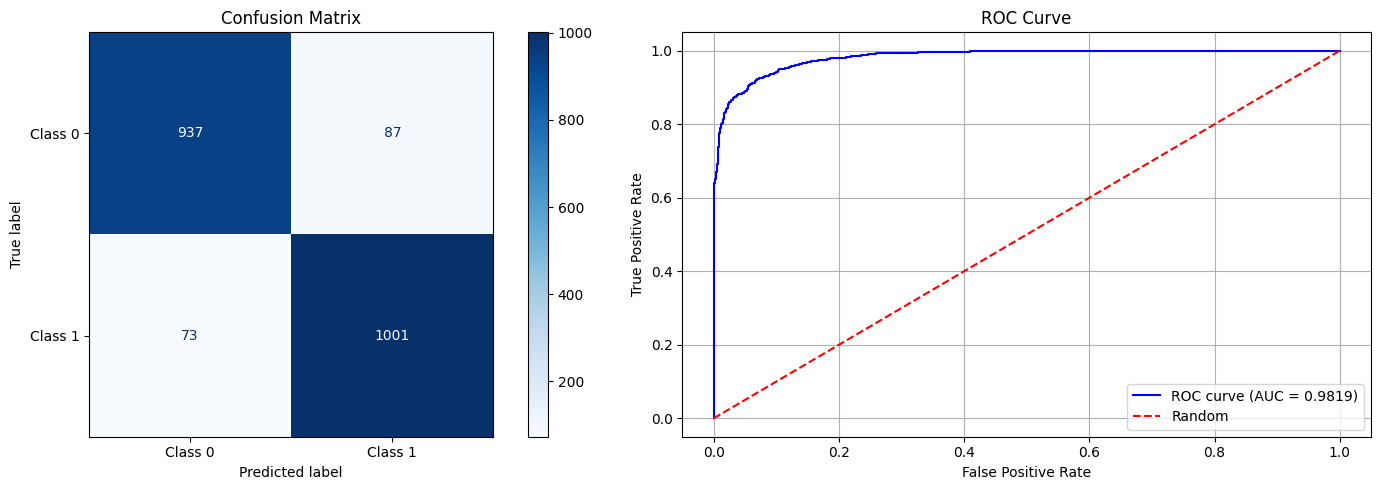


ТОП-10 ВАЖНЕЙШИХ ПРИЗНАКОВ:
                       feature  importance
25                InterestRate        1338
27      TotalDebtToIncomeRatio        1234
23                    NetWorth        1186
3                   LoanAmount         966
17                 TotalAssets         955
14       LengthOfCreditHistory         864
20  UtilityBillsPaymentHistory         835
1                 AnnualIncome         787
15       SavingsAccountBalance         774
6          MonthlyDebtPayments         770


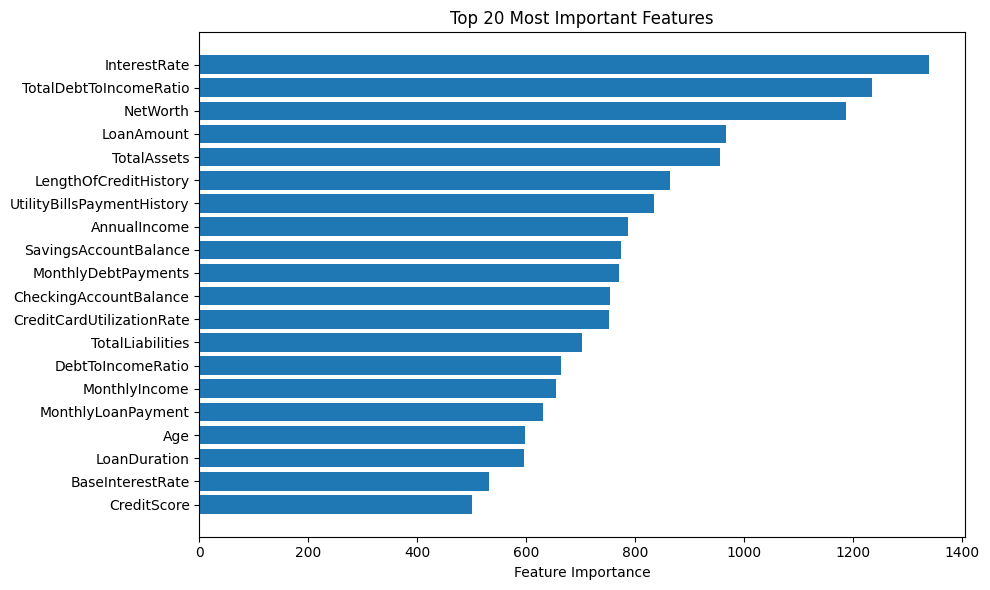

In [40]:
print("\n" + "="*70)
print("ФИНАЛЬНАЯ ПРОВЕРКА МОДЕЛИ")
print("="*70)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("\nОТЧЕТ О КЛАССИФИКАЦИИ:")
print(classification_report(y_val, y_pred_val, target_names=['Class 0', 'Class 1']))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix')

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_val)
axes[1].plot(fpr, tpr, 'b-', label=f'ROC curve (AUC = {sklearn_roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'r--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\nТОП-10 ВАЖНЕЙШИХ ПРИЗНАКОВ:")
try:

    feature_names = []

    feature_names.extend(num_features)

    categorical_transformer = preprocessor.named_transformers_['cat']
    if hasattr(categorical_transformer.named_steps['encoder'], 'get_feature_names_out'):
        cat_features_encoded = categorical_transformer.named_steps['encoder'].get_feature_names_out(cat_features)
        feature_names.extend(cat_features_encoded)
    else:
        for i, col in enumerate(cat_features):
            feature_names.append(f"{col}_encoded_{i}")

    importance = final_model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'feature': feature_names[:len(importance)],
        'importance': importance
    })

    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    print(feature_importance_df.head(10))

    plt.figure(figsize=(10, 6))
    top_20 = feature_importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['importance'])
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Не удалось получить важность признаков: {e}")

__11. Итоги__

In [ ]:
print("\n" + "="*80)
print("ИТОГОВЫЙ ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ")
print("="*80)

print("Сравнение алгоритмов градиентного бустинга:")
display(f"    - LightGBM: {results.get('LightGBM', 'N/A'):.4f}")
display(f"    - XGBoost: {results.get('XGBoost', 'N/A'):.4f}")
display(f"    - Sklearn GBM: {results.get('Sklearn GBM', 'N/A'):.4f}")
display(f"    - CatBoost: {results.get('CatBoost', 'N/A'):.4f}")
display(f"   Лучшая модель: {best_model_name} (ROC-AUC: {best_model_score:.4f})")

print("Реализованные метрики:")
display(f"    - Accuracy: разница {abs(custom_acc - sklearn_acc):.6f}")
display(f"    - Precision: разница {abs(custom_prec - sklearn_prec):.6f}")
display(f"    - Recall: разница {abs(custom_rec - sklearn_rec):.6f}")
display(f"    - F1-Score: разница {abs(custom_f1 - sklearn_f1):.6f}")

print("\nДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ (за 2 балла):")
print(f"✓ ROC-AUC: разница {abs(custom_roc_auc - sklearn_roc_auc):.6f}")
print(f"✓ PR-AUC: разница {abs(custom_pr_auc - sklearn_pr_auc):.6f}")

print("\nРЕЗУЛЬТАТЫ МОДЕЛИ НА ВАЛИДАЦИИ:")
display(f"Accuracy: {sklearn_acc:.4f}")
display(f"Precision: {sklearn_prec:.4f}")
display(f"Recall: {sklearn_rec:.4f}")
display(f"F1-Score: {sklearn_f1:.4f}")
display(f"ROC-AUC: {sklearn_roc_auc:.4f}")
display(f"PR-AUC: {sklearn_pr_auc:.4f}")


if sklearn_roc_auc > 0.75:
    print("ROC-AUC > 0.75")
    print(f"Наш ROC-AUC: {custom_roc_auc:.4f}")
else:
    print(f"\nВНИМАНИЕ: ROC-AUC = {custom_roc_auc:.4f} < 0.75")
    print("   Необходимо улучшить модель для допуска к защите.")

print("\n" + "="*80)


ИТОГОВЫЙ ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ
Сравнение алгоритмов градиентного бустинга:


'    - LightGBM: 0.9809'

'    - XGBoost: 0.9805'

'    - Sklearn GBM: 0.9803'

'    - CatBoost: 0.9794'

'   Лучшая модель: LightGBM (ROC-AUC: 0.9809)'

Реализованные метрики:


'    - Accuracy: разница 0.000000'

'    - Precision: разница 0.000000'

'    - Recall: разница 0.000000'

'    - F1-Score: разница 0.000000'


ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ (за 2 балла):
✓ ROC-AUC: разница 0.000000
✓ PR-AUC: разница 0.000007

РЕЗУЛЬТАТЫ МОДЕЛИ НА ВАЛИДАЦИИ:


'Accuracy: 0.9237'

'Precision: 0.9200'

'Recall: 0.9320'

'F1-Score: 0.9260'

'ROC-AUC: 0.9819'

'PR-AUC: 0.9838'

ROC-AUC > 0.75
Наш ROC-AUC: 0.9819 0.9819

